In [1]:
import os
import requests
import fsspec

import time
import numpy as np
import pandas as pd

from functools import partial
import subprocess

import torch
from tqdm.notebook import trange, tqdm
from tqdm import tqdm
from datasets import load_dataset

from pytorchltr.evaluation import ndcg

# df = pd.read_csv("../rank.csv")
label_class = [
    "Qwen-Qwen2.5-3B-Instruct-PL", # 0
    "Qwen-Qwen2.5-3B-Instruct-NL", # 1
    "Qwen-Qwen2.5-7B-Instruct-PL", # 2
    "Qwen-Qwen2.5-7B-Instruct-NL", # 3
    "Qwen-Qwen2.5-14B-Instruct-PL",# 4
    "Qwen-Qwen2.5-14B-Instruct-NL",# 5
    "Qwen-Qwen2.5-32B-Instruct-PL",# 6
    "Qwen-Qwen2.5-32B-Instruct-NL",# 7
    "Qwen-Qwen2.5-72B-Instruct-PL",# 8
    "Qwen-Qwen2.5-72B-Instruct-NL",# 9
]

/home/lsutawik/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Construct Ranking

In [2]:
df = pd.read_csv("../train.csv", index_col=0)
task_df = df[df.task.str.contains("math_")]

task_df["size"] = task_df["model"].apply(lambda x: int(x.split("-")[2][:-1]))
task_df["compute"] = task_df.apply(lambda row: 2 * row["size"] * row["output_tokens"], axis=1)

task_df.pivot_table(
    index=["size", "model", "solve"],
    columns=["task"],
    values=["accuracy", "compute"],
    # values=["accuracy", "output_tokens"],
    aggfunc="mean",
).swaplevel(0, 1, axis=1).sort_index(axis=1)


/tmp/ipykernel_2206051/325695225.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_df["size"] = task_df["model"].apply(lambda x: int(x.split("-")[2][:-1]))
/tmp/ipykernel_2206051/325695225.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_df["compute"] = task_df.apply(lambda row: 2 * row["size"] * row["output_tokens"], axis=1)


task                                 math_algebra                \
                                         accuracy       compute   
size model                     solve                              
3    Qwen-Qwen2.5-3B-Instruct  NL        0.633028   3897.798165   
                               PL        0.376147   1481.027523   
7    Qwen-Qwen2.5-7B-Instruct  NL        0.710245   8741.801223   
                               PL        0.520642   3133.666667   
14   Qwen-Qwen2.5-14B-Instruct NL        0.740061  17346.963303   
                               PL        0.545872   5951.691131   
32   Qwen-Qwen2.5-32B-Instruct NL        0.749235  37933.602446   
                               PL        0.602446  13847.192661   
72   Qwen-Qwen2.5-72B-Instruct NL        0.756116  94599.743119   
                               PL        0.576453  27081.688073   

task                                 math_counting_and_probability  \
                                                          accuracy   
size model                     solve                                 
3    Qwen-Qwen2.5-3B-Instruct  NL                         0.233092   
                               PL                         0.183575   
7    Qwen-Qwen2.5-7B-Instruct  NL                         0.352657   
                               PL                         0.391304   
14   Qwen-Qwen2.5-14B-Instruct NL                         0.396135   
                               PL                         0.409420   
32   Qwen-Qwen2.5-32B-Instruct NL                         0.442029   
                               PL                         0.508454   
72   Qwen-Qwen2.5-72B-Instruct NL                         0.433575   
                               PL                         0.525362   

task                                                math_geometry  \
                                            compute      accuracy   
size model                     solve                                
3    Qwen-Qwen2.5-3B-Instruct  NL       4609.260870      0.262074   
                               PL       1551.702899      0.079968   
7    Qwen-Qwen2.5-7B-Instruct  NL      10801.879227      0.325416   
                               PL       3338.019324      0.155978   
14   Qwen-Qwen2.5-14B-Instruct NL      20866.966184      0.368963   
                               PL       6581.893720      0.189232   
32   Qwen-Qwen2.5-32B-Instruct NL      44652.135266      0.421219   
                               PL      15454.376812      0.217736   
72   Qwen-Qwen2.5-72B-Instruct NL     121891.652174      0.413302   
                               PL      31484.000000      0.194774   

task                                                math_intermediate_algebra  \
                                            compute                  accuracy   
size model                     solve                                            
3    Qwen-Qwen2.5-3B-Instruct  NL       5324.057007                  0.226107   
                               PL       2196.584323                  0.151515   
7    Qwen-Qwen2.5-7B-Instruct  NL      12033.094220                  0.328671   
                               PL       5227.741884                  0.236985   
14   Qwen-Qwen2.5-14B-Instruct NL      23931.287411                  0.365967   
                               PL      10152.139351                  0.239316   
32   Qwen-Qwen2.5-32B-Instruct NL      48754.926366                  0.385392   
                               PL      22679.968329                  0.288267   
72   Qwen-Qwen2.5-72B-Instruct NL     134764.617577                  0.378399   
                               PL      44470.118765                  0.287490   

task                                                math_number_theory  \
                                            compute           accuracy   
size model                     solve                                     
3    Qwen-Qwen2.5-3B-Instruct  NL       618

In [3]:
task_df

,accuracy,output_tokens,text,task,model,solve,num,size,compute
idx,,,,,,,,,
0,1,914,"Square ABCD has its center at $(8,-8)$ and has...",math_geometry,Qwen-Qwen2.5-7B-Instruct,NL,0,7,12796
1,1,446,A scalene triangle has side lengths which are ...,math_geometry,Qwen-Qwen2.5-7B-Instruct,NL,0,7,6244
2,0,547,The field shown has been planted uniformly wit...,math_geometry,Qwen-Qwen2.5-7B-Instruct,NL,0,7,7658
3,0,534,"A triangle with sides of 5, 12, and 13 has bot...",math_geometry,Qwen-Qwen2.5-7B-Instruct,NL,0,7,7476
4,1,789,In a trapezoid $ABCD$ with $AB$ parallel to $C...,math_geometry,Qwen-Qwen2.5-7B-Instruct,NL,0,7,11046
...,...,...,...,...,...,...,...,...,...
247,1,675,For how many three-digit positive integers is ...,math_prealgebra,Qwen-Qwen2.5-32B-Instruct,NL,2,32,43200
248,1,904,"Tracy had a bag of candies, and none of the ca...",math_prealgebra,Qwen-Qwen2.5-32B-Instruct,NL,2,32,57856
249,1,258,"In a right-angled triangle, the sum of the squ...",math_prealgebra,Qwen-Qwen2.5-32B-Instruct,NL,2,32,16512


In [ ]:
from routing.ranker import rank_model_solution_pair

train_df = pd.DataFrame()
test_df = pd.DataFrame()
valid_df = pd.DataFrame()

route_performance = []

def score_fn(row, lmbda=0.1):
    return row["accuracy"] / np.log10(row["compute"] ** lmbda)

# for lmbda in [0.1, 0.2, 0.4, 0.8, 1.0]:
for lmbda in [1.0]:
    for task_name in task_df.task.unique():
        _task_df = task_df[task_df["task"] == task_name]
        _rank_df = _task_df.pivot_table(
            index=["idx"],
            columns=["model", "solve"],
            values=["accuracy", "output_tokens"],
            aggfunc="mean",
        )

        _task_df.reset_index(inplace=True)

        rank_fn = partial(rank_model_solution_pair, lmbda=lmbda, score_fn=partial(score_fn, lmbda=lmbda))
        _rank_df["label"] = _rank_df.apply(rank_fn, axis=1)
        _rank_df.reset_index(inplace=True)

        _rank_df.columns = ['_'.join(filter(None, col)).strip() for col in _rank_df.columns.values]
        _rank_df = _rank_df[['idx', 'label']]
        _rank_df["route"] = _rank_df["label"].apply(lambda x: label_class[x[0]])
        _rank_df["model"] = _rank_df["route"].apply(lambda x: "-".join(x.split("-")[:-1]))
        _rank_df["solve"] = _rank_df["route"].apply(lambda x: x.split("-")[-1])

        _route_df = _rank_df.merge(
                _task_df[["idx", "model", "solve", "accuracy", "output_tokens"]],
                on=["idx", "model", "solve"],
                how="left"
            )

        _text_df = _task_df[
            (_task_df["model"] == _task_df["model"].unique()[0])
            & (_task_df["solve"] == "PL")
            & (_task_df["num"] == 0)
        ]
        _rank_df = _text_df[['idx', 'text']].merge(_rank_df.reset_index(drop=True)[['label', 'idx']], on='idx')
        _rank_df["task"] = task_name

        _route_df["size"] = _route_df["model"].apply(lambda x: int(x.split("-")[2][:-1]))
        _route_df["compute"] = 2 * _route_df["size"] * _route_df["output_tokens"]

        accuracy, output_tokens, compute = _route_df[
            ["accuracy", "output_tokens", "compute"]
        ].mean().values

        route_performance.append({
            "task": task_name,
            "accuracy": accuracy,
            "output_tokens": output_tokens,
            "compute": compute,
            "solve": lmbda,
            "model": "route",
        })

        _rank_df.sample(frac=1).reset_index(drop=True)
        task_size = len(_rank_df)
        train_size = int(task_size * 0.8)
        valid_size = int(task_size * 0.1)
        test_size = int(task_size * 0.1)
        train_df = pd.concat([train_df, _rank_df.iloc[:train_size]], ignore_index=True)
        valid_df = pd.concat([valid_df, _rank_df.iloc[train_size:train_size + valid_size]], ignore_index=True)
        test_df = pd.concat([test_df, _rank_df.iloc[-test_size-1:]], ignore_index=True)

route_df = pd.DataFrame(route_performance)

In [12]:
_task_df = task_df[task_df["task"] == "math_algebra"]

_rank_df = _task_df.pivot_table(
            index=["idx"],
            columns=["model", "solve"],
            values=["accuracy", "output_tokens"],
            aggfunc="mean",
        )
_rank_df = _rank_df[:10]
_rank_df.columns = pd.MultiIndex.from_tuples(
    [(a, f"{b}-{c}") for a, b, c in _rank_df.columns.values],
    names=["metric", "route"]
    )
# _rank_df = _rank_df.stack(level="route").unstack(level="idx")

for i in range(10):
    row = _rank_df.iloc[i]
    model = row["accuracy"].index
    size = [int(m.split("-")[2][:-1]) for m in model]
    # score = row["accuracy"] / (lmbda * np.log10(row["output_tokens"] * 2 * size))
    acc = row["accuracy"]
    compute = row["output_tokens"] * 2 * size
    for lmbda in [0.1, 0.2, 0.4, 0.8, 1.0]:
        print(f"Lambda: {lmbda}")
        # score = row["accuracy"] * (compute)**lmbda
        score = np.log10(1+row["accuracy"]/compute**lmbda)
        score = score.sort_values(ascending=True)
        df = pd.concat([acc, compute, score], axis=1)
        df.columns = ["Accuracy", "Compute", "Score"]
        df.sort_values(by="Score", ascending=False, inplace=True)
        display(df)
    # print(row["output_tokens"] * 2 * size)
    # display(row.index)
    break
# _rank_df.swaplevel(0, 1, axis=1).sort_index(axis=1)

# lmbda=0.1
# def rank_fn(row):
#     row = row.unstack(level=0).reset_index()
#     row["size"] = row["model"].apply(lambda x: int(x.split("-")[2][:-1]))
#     row["compute"] = 2 * row["size"] * row["output_tokens"]
#     row["score"] = row["accuracy"] / (lmbda * np.log10(row["compute"]))
#     row.sort_values(by=['score'], ascending=[False], inplace=True)

#     return row["score"]

# _rank_df["score"] = _rank_df.apply(
#     rank_fn,
#     axis=1)
# # # lmbda = 0.1
# # # _df["score"] = 
# # # _df.sort_values(by=['score'], ascending=[False])
# _rank_df

Lambda: 0.1


,Accuracy,Compute,Score
route,,,
Qwen-Qwen2.5-3B-Instruct-PL,1.000000,2090.000000,0.166007
Qwen-Qwen2.5-7B-Instruct-NL,1.000000,9174.666667,0.146609
Qwen-Qwen2.5-32B-Instruct-PL,1.000000,13354.666667,0.142000
Qwen-Qwen2.5-14B-Instruct-NL,1.000000,18433.333333,0.138141
Qwen-Qwen2.5-32B-Instruct-NL,1.000000,34197.333333,0.130992
Qwen-Qwen2.5-72B-Instruct-NL,1.000000,92256.000000,0.120175
Qwen-Qwen2.5-7B-Instruct-PL,0.666667,3271.333333,0.112867
Qwen-Qwen2.5-3B-Instruct-NL,0.666667,3902.000000,0.111126
Qwen-Qwen2.5-72B-Instruct-PL,0.666667,31104.000000,0.092346


Lambda: 0.2


,Accuracy,Compute,Score
route,,,
Qwen-Qwen2.5-3B-Instruct-PL,1.000000,2090.000000,0.085203
Qwen-Qwen2.5-7B-Instruct-NL,1.000000,9174.666667,0.064923
Qwen-Qwen2.5-32B-Instruct-PL,1.000000,13354.666667,0.060539
Qwen-Qwen2.5-14B-Instruct-NL,1.000000,18433.333333,0.056997
Qwen-Qwen2.5-7B-Instruct-PL,0.666667,3271.333333,0.053892
Qwen-Qwen2.5-3B-Instruct-NL,0.666667,3902.000000,0.052133
Qwen-Qwen2.5-32B-Instruct-NL,1.000000,34197.333333,0.050742
Qwen-Qwen2.5-72B-Instruct-NL,1.000000,92256.000000,0.042034
Qwen-Qwen2.5-72B-Instruct-PL,0.666667,31104.000000,0.035112


Lambda: 0.4


,Accuracy,Compute,Score
route,,,
Qwen-Qwen2.5-3B-Instruct-PL,1.000000,2090.000000,0.019940
Qwen-Qwen2.5-7B-Instruct-PL,0.666667,3271.333333,0.011225
Qwen-Qwen2.5-7B-Instruct-NL,1.000000,9174.666667,0.011147
Qwen-Qwen2.5-3B-Instruct-NL,0.666667,3902.000000,0.010470
Qwen-Qwen2.5-32B-Instruct-PL,1.000000,13354.666667,0.009610
Qwen-Qwen2.5-14B-Instruct-NL,1.000000,18433.333333,0.008459
Qwen-Qwen2.5-32B-Instruct-NL,1.000000,34197.333333,0.006620
Qwen-Qwen2.5-72B-Instruct-PL,0.666667,31104.000000,0.004595
Qwen-Qwen2.5-72B-Instruct-NL,1.000000,92256.000000,0.004462


Lambda: 0.8


,Accuracy,Compute,Score
route,,,
Qwen-Qwen2.5-3B-Instruct-PL,1.000000,2090.000000,0.000958
Qwen-Qwen2.5-7B-Instruct-PL,0.666667,3271.333333,0.000446
Qwen-Qwen2.5-3B-Instruct-NL,0.666667,3902.000000,0.000388
Qwen-Qwen2.5-7B-Instruct-NL,1.000000,9174.666667,0.000293
Qwen-Qwen2.5-32B-Instruct-PL,1.000000,13354.666667,0.000217
Qwen-Qwen2.5-14B-Instruct-NL,1.000000,18433.333333,0.000168
Qwen-Qwen2.5-14B-Instruct-PL,0.333333,6673.333333,0.000126
Qwen-Qwen2.5-32B-Instruct-NL,1.000000,34197.333333,0.000102
Qwen-Qwen2.5-72B-Instruct-PL,0.666667,31104.000000,0.000074


Lambda: 1.0


,Accuracy,Compute,Score
route,,,
Qwen-Qwen2.5-3B-Instruct-PL,1.000000,2090.000000,0.000208
Qwen-Qwen2.5-7B-Instruct-PL,0.666667,3271.333333,0.000088
Qwen-Qwen2.5-3B-Instruct-NL,0.666667,3902.000000,0.000074
Qwen-Qwen2.5-7B-Instruct-NL,1.000000,9174.666667,0.000047
Qwen-Qwen2.5-32B-Instruct-PL,1.000000,13354.666667,0.000033
Qwen-Qwen2.5-14B-Instruct-NL,1.000000,18433.333333,0.000024
Qwen-Qwen2.5-14B-Instruct-PL,0.333333,6673.333333,0.000022
Qwen-Qwen2.5-32B-Instruct-NL,1.000000,34197.333333,0.000013
Qwen-Qwen2.5-72B-Instruct-PL,0.666667,31104.000000,0.000009


In [128]:
route_df.pivot_table(
    index=["model", "solve"],
    columns=["task"],
    values=["accuracy", "compute"],
    aggfunc="mean",
).swaplevel(0, 1, axis=1).sort_index(axis=1)
# display(_rank_df.head())
# display(_task_df.head())



task        math_algebra              math_counting_and_probability  \
                accuracy      compute                      accuracy   
model solve                                                           
route 0.1       0.828746  7489.120795                      0.721014   
      0.2       0.828746  7489.120795                      0.721014   
      0.4       0.828746  7489.120795                      0.721014   
      0.8       0.828746  7489.120795                      0.721014   
      1.0       0.828746  7489.120795                      0.721014   

task                      math_geometry                \
                  compute      accuracy       compute   
model solve                                             
route 0.1    14640.437198      0.547902  25624.810768   
      0.2    14640.437198      0.547902  25624.810768   
      0.4    14640.437198      0.547902  25624.810768   
      0.8    14640.437198      0.547902  25624.810768   
      1.0    14640.437198      0.547902  25624.810768   

task        math_intermediate_algebra               math_number_theory  \
                             accuracy       compute           accuracy   
model solve                                                              
route 0.1                    0.599845  24044.638695           0.899894   
      0.2                    0.599845  24044.638695           0.899894   
      0.4                    0.599845  24044.638695           0.899894   
      0.8                    0.599845  24044.638695           0.899894   
      1.0                    0.599845  24044.638695           0.899894   

task                      math_prealgebra              math_precalculus  \
                  compute        accuracy      compute         accuracy   
model solve                                                               
route 0.1    10852.083067        0.883598  5852.407407          0.52354   
      0.2    10852.083067        0.883598  5852.407407          0.52354   
      0.4    10852.083067        0.883598  5852.407407          0.52354   
      0.8    10852.083067        0.883598  5852.407407          0.52354   
      1.0    10852.083067        0.883598  5852.407407          0.52354   

task                       
                  compute  
model solve                
route 0.1    26644.549906  
      0.2    26644.549906  
      0.4    26644.549906  
      0.8    26644.549906  
      1.0    26644.549906

## Analysis of Training Data

In [30]:
train_df = pd.read_json("../data/MATH:0.1/train.jsonl", lines=True)
train_df["split"] = "train"
valid_df = pd.read_json("../data/MATH:0.1/valid.jsonl", lines=True)
valid_df["split"] = "valid"
test_df = pd.read_json("../data/MATH:0.1/test.jsonl", lines=True)
test_df["split"] = "test"

data_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)

In [58]:
for choice in range(10):
    data_df[f"{choice}"] = data_df["label"].apply(lambda x: x[0] == choice)

class_df = data_df.pivot_table(
    index="task",
    values=[f"{i}" for i in range(10)],
    # values=["accuracy", "compute"],
).reset_index()

display(class_df)

def sample_from_distribution(class_probs, num_samples):
    return np.random.choice(len(class_probs), size=num_samples, p=class_probs)

,task,0,1,2,3,4,5,6,7,8,9
0,math_algebra,0.202299,0.268966,0.140230,0.080460,0.068966,0.188506,0.032184,0.009195,0.004598,0.004598
1,math_counting_and_probability,0.083636,0.065455,0.181818,0.101818,0.094545,0.221818,0.127273,0.036364,0.065455,0.021818
2,math_geometry,0.035629,0.135392,0.064133,0.114014,0.059382,0.391924,0.049881,0.083135,0.019002,0.047506
3,math_intermediate_algebra,0.077103,0.102804,0.079439,0.126168,0.070093,0.362150,0.060748,0.063084,0.021028,0.037383
4,math_number_theory,0.281150,0.086262,0.178914,0.057508,0.102236,0.086262,0.130990,0.012780,0.041534,0.022364
5,math_prealgebra,0.313492,0.170635,0.190476,0.071429,0.055556,0.119048,0.043651,0.019841,0.011905,0.003968
6,math_precalculus,0.034091,0.102273,0.090909,0.090909,0.056818,0.443182,0.045455,0.079545,0.017045,0.039773
7,mmlu_redux_college_mathematics,0.118812,0.188119,0.099010,0.237624,0.099010,0.128713,0.029703,0.039604,0.009901,0.049505
8,mmlu_redux_elementary_mathematics,0.346535,0.425743,0.079208,0.089109,0.009901,0.039604,0.000000,0.009901,0.000000,0.000000
9,mmlu_redux_high_school_mathematics,0.227723,0.396040,0.069307,0.138614,0.029703,0.079208,0.000000,0.059406,0.000000,0.000000


## Analysis

In [2]:
def get_response(query, model="jason9693/Qwen2.5-1.5B-apeach", api_url="http://localhost:8000/classify"):

    response = requests.post(
        api_url,
        headers={"User-Agent": "Test Client"},
        json={
            "model": model,
            "input": [query],
        }
    )

    return response.json()

# r = post_http_request(
#     payload = {
#         # "model": "jason9693/Qwen2.5-1.5B-apeach",
#         "model": "/data/user_data/lsutawik/01-solution-path-routing/qwen2.5-0.5b-math-algebra/",
#         "input": ["Suppose that for some $a,b,c$ we have $a+b+c = 6$, $ab+ac+bc = 5$ and $abc = -12$. What is $a^3+b^3+c^3$?\nReason step by step and put your final answer within \\boxed{}."],
#     },
#     # api_url = f"http://localhost:8100/classify"
#     api_url = f"http://localhost:8000/classify"
#     )

# r.json()

## Evaluate on Test Set of Training Split

In [ ]:
# model_path = "/data/user_data/lsutawik/01-solution-path-routing/qwen2.5-0.5b:math:1.0-NEW/"
model_path = "/data/user_data/lsutawik/01-solution-path-routing/"
# model_path = "/data/user_data/lsutawik/01-solution-path-routing/relevance_variations/"
# model_path = "/data/user_data/lsutawik/test_spr_route/"

# check if file exists .csv
task_prefix = "math"
overwrite = True

model_list = [
    "linear-qwen2.5-0.5b:math:1.0",
    "qwen2.5-0.5b:math:1.0",
    "qwen2.5-1.5b:math:1.0",
    "qwen2.5-7b:math:1.0",
    # "linear_softmax-qwen2.5-0.5b:math:1.0",
    # "power_softmax-qwen2.5-0.5b:math:1.0",
    # "power-qwen2.5-0.5b:math:1.0",
    # "softmax-qwen2.5-0.5b:math:1.0",
    # "qwen2.5-3b:MATH:0.1/checkpoint-1152",
    # "power_new_00-qwen2.5-0.5b:MATH:0.1",
    # "power_new_01-qwen2.5-0.5b:MATH:0.1",
    # "power_new_02-qwen2.5-0.5b:MATH:0.1",
    # "power_new_03-qwen2.5-0.5b:MATH:0.1",
    "linear_new_20-qwen2.5-0.5b:MATH:0.1",
    "linear_new_21-qwen2.5-0.5b:MATH:0.1",
    # "linear_new_22-qwen2.5-0.5b:MATH:0.1",
    # "linear_new_23-qwen2.5-0.5b:MATH:0.1",
    # "linear_new_00-qwen2.5-0.5b:MATH:0.1",
    # "linear_new_01-qwen2.5-0.5b:MATH:0.1",
    # "linear_new_02-qwen2.5-0.5b:MATH:0.1",
    # "linear_new_03-qwen2.5-0.5b:MATH:0.1",
]

if os.path.exists("route_pred_df.csv") and overwrite == False:
    route_pred_df = pd.read_csv("route_pred_df.csv")
else:
    route_pred_dict = []
    for model_name in model_list:

        print(f"Processing model: {model_name}")
        model, data_name, lambda_value = model_name.split("/")[0].split(":")
        try:
            num = int(model.split("-")[0].split("_")[-1][0])
            route_type = model.split("-")[0].split("_")[0]
        except:
            num = 0
            route_type = "None"

        model_full_path = os.path.join(model_path, model_name)
        print(model_full_path)

        if not os.path.exists(model_full_path):
            continue
        elif not any(file.endswith(".safetensors") for file in os.listdir(model_full_path)):
            continue

        command = f"vllm serve {model_full_path} --task classify --port 8100"
        process = subprocess.Popen(command.split(), shell=False, stdout=subprocess.DEVNULL)

        while True:
            # Check API Health
            try:
                r = requests.get("http://0.0.0.0:8100/health")
                if r.status_code == 200:
                    break
            except requests.exceptions.ConnectionError:
                print("Waiting for API to be ready...")
                time.sleep(15)

        test_dataset = load_dataset("json", data_dir=f"../data/{data_name}:{lambda_value}/", split="test")

        for i in range(len(test_dataset)):
            text = test_dataset[i]["text"]
            label = test_dataset[i]["label"]
            rank_accuracy = test_dataset[i]["rank_accuracy"]
            rank_compute = test_dataset[i]["rank_compute"]

            raw_response = get_response(
                text,
                model=model_full_path,
                api_url="http://localhost:8100/classify"
                )
            response = raw_response['data'][0]['probs']

            sorted_response = sorted(response, reverse=True)
            predicted_rank = [response.index(resp) for resp in sorted_response]

            route_pred_dict.append({
                "model": model_name,
                "task": task_prefix,
                "predicted_rank": predicted_rank,
                "probs": response,
                "label": label,
                "route_type": route_type,
                "num": num,
                "rank_accuracy": rank_accuracy,
                "rank_compute": rank_compute,
                # "size": size,
            })

        process.terminate()
        process.wait()

    route_pred_df = pd.DataFrame(route_pred_dict)
    route_pred_df.to_csv(
        "route_pred_df.csv",
        index=False,
    )


Processing model: linear-qwen2.5-0.5b:math:1.0
/data/user_data/lsutawik/01-solution-path-routing/linear-qwen2.5-0.5b:math:1.0
Waiting for API to be ready...
Waiting for API to be ready...


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  6.15it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  6.14it/s]

INFO:     Started server process [1287469]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
[rank0]:[W620 13:31:48.674926574 ProcessGroupNCCL.cpp:1476] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.


Processing model: linear_new_20-qwen2.5-0.5b:MATH:0.1
/data/user_data/lsutawik/01-solution-path-routing/linear_new_20-qwen2.5-0.5b:MATH:0.1
Waiting for API to be ready...
Waiting for API to be ready...


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Waiting for API to be ready...


Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:11<00:00, 11.42s/it]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:11<00:00, 11.42s/it]

INFO:     Started server process [1287665]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
[rank0]:[W620 13:32:39.917215129 ProcessGroupNCCL.cpp:1476] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.


Processing model: linear_new_21-qwen2.5-0.5b:MATH:0.1
/data/user_data/lsutawik/01-solution-path-routing/linear_new_21-qwen2.5-0.5b:MATH:0.1
Waiting for API to be ready...
Waiting for API to be ready...


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:01<00:00,  1.91s/it]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:01<00:00,  1.91s/it]



Waiting for API to be ready...


INFO:     Started server process [1287841]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
[rank0]:[W620 13:33:29.437366408 ProcessGroupNCCL.cpp:1476] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.


In [21]:
try:
    predictions = torch.FloatTensor(route_pred_df["probs"].apply(lambda x: eval(x)).tolist())
    labels = torch.tensor(route_pred_df["label"].apply(lambda x: eval(x)).tolist())
except Exception as e:
    predictions = torch.FloatTensor(route_pred_df["probs"])
    labels = torch.tensor(route_pred_df["label"])

bs, n = labels.shape
n_size = torch.tensor([n]*bs)

score = torch.tensor([9,8,7,6,5,4,3,2,1,0], dtype=torch.float)
# score = torch.tensor([5,4,3,2,1,0,0,0,0,0], dtype=torch.float)
relevance = torch.zeros_like(labels, dtype=torch.float)

# Fill relevance: for each row, assign scores according to x's rank
for i in range(labels.size(0)):
    relevance[i][labels[i]] = score

ndcg_1 = ndcg(predictions, relevance, n_size, k=1, exp=False)
ndcg_2 = ndcg(predictions, relevance, n_size, k=2, exp=False)
ndcg_4 = ndcg(predictions, relevance, n_size, k=4, exp=False)
ndcg_10 = ndcg(predictions, relevance, n_size, k=10, exp=False)
ndcg_avg = (ndcg_1 + ndcg_2 + ndcg_4 + ndcg_10)/4

route_pred_df["ndcg"] = ndcg_avg
route_pred_df["ndcg_1"] = ndcg_1
route_pred_df["ndcg_2"] = ndcg_2
route_pred_df["ndcg_4"] = ndcg_4
route_pred_df["ndcg_10"] = ndcg_10

In [24]:
route_pred_df["top_predicted_accuracy"] = route_pred_df.apply(
    lambda x: x["predicted_rank"][0] == x["label"][0], axis=1
)
route_pred_df["accuracy_from_predicted_rank"] = route_pred_df.apply(lambda x: x["rank_accuracy"][x["predicted_rank"][0]], axis=1)
route_pred_df["accuracy_from_rank"] = route_pred_df.apply(lambda x: x["rank_accuracy"][0], axis=1)
for m in range(10):
    route_pred_df[label_class[m]] = route_pred_df.apply(lambda x: x["rank_accuracy"][x["label"].index(m)], axis=1)

route_pred_df[["accuracy_from_rank"]+[label_class[m] for m in range(10)]].mean()

accuracy_from_rank              0.776529
Qwen-Qwen2.5-3B-Instruct-PL     0.309613
Qwen-Qwen2.5-3B-Instruct-NL     0.470662
Qwen-Qwen2.5-7B-Instruct-PL     0.435705
Qwen-Qwen2.5-7B-Instruct-NL     0.578027
Qwen-Qwen2.5-14B-Instruct-PL    0.460674
Qwen-Qwen2.5-14B-Instruct-NL    0.591760
Qwen-Qwen2.5-32B-Instruct-PL    0.534332
Qwen-Qwen2.5-32B-Instruct-NL    0.622971
Qwen-Qwen2.5-72B-Instruct-PL    0.510612
Qwen-Qwen2.5-72B-Instruct-NL    0.617978
dtype: float64

In [25]:
route_pred_df.pivot_table(
    index=["model"],
    values=["accuracy_from_predicted_rank", "top_predicted_accuracy", "ndcg", "ndcg_1", "ndcg_2", "ndcg_4", "ndcg_10"],
    aggfunc="mean"
)


,accuracy_from_predicted_rank,ndcg,ndcg_1,ndcg_10,ndcg_2,ndcg_4,top_predicted_accuracy
model,,,,,,,
linear-qwen2.5-0.5b:math:1.0,0.535581,0.746103,0.699958,0.873818,0.684968,0.725667,0.254682
linear_new_20-qwen2.5-0.5b:MATH:0.1,0.559301,0.756717,0.707865,0.880419,0.702650,0.735933,0.250936
linear_new_21-qwen2.5-0.5b:MATH:0.1,0.534332,0.754042,0.710362,0.877513,0.702063,0.726229,0.224719


## Predict Routing Evaluation Data

### Utils Functions

#### Routing

In [2]:
def get_routing(model_name, task_name, base_path, top_k=3, api_url="http://localhost:8100/classify"):

    model_task_solve = f"Qwen-Qwen2.5-3B-Instruct:{task_name}:NL:00"
    eval_data = load_dataset("json", data_files=os.path.join(base_path, model_task_solve, "output.jsonl"), split="train")

    routing_dict = []
    prediction_dict = []
    for i in tqdm(range(len(eval_data)), total=len(eval_data)):
        text = eval_data[i]["step"][0]["full_input"][0]["content"]
        response = get_response(
            text,
            model=model_name,
            api_url=api_url,
            )['data'][0]['probs']
        sorted_response = sorted(response, reverse=True)
        predicted_rank = [response.index(resp) for resp in sorted_response]
        for k, model_solve in enumerate(predicted_rank[:top_k]):
            *model, solve = label_class[model_solve].split("-")
            model = "-".join(model)
            routing_dict.append({
                "idx": i,
                "k": k,
                "model": model,
                "solve": solve,
                "task": task_name,
            })

    routing_df = pd.DataFrame(routing_dict)
    prediction_df = pd.DataFrame(prediction_dict)
    # return routing_df

    score_dict = []
    for _, x in routing_df.iterrows():    
        accuracy, output_tokens = solution_df[
            (solution_df["idx"] == x["idx"])
            & (solution_df["task"] == x["task"])
            & (solution_df["model"] == x["model"])
            & (solution_df["solve"] == x["solve"])
        ][["accuracy", "output_tokens"]].mean()
        score_dict.append({
            "idx": x["idx"],
            "k": x["k"],
            "model": x["model"],
            "solve": x["solve"],
            "task": x["task"],
            "accuracy": accuracy,
            "output_tokens": output_tokens,
        })

    score_df = pd.DataFrame(score_dict)
    return score_df, prediction_df

#### Get DataFrames

In [3]:
def get_solve_df(solution_path, task_prefix, model_prefix, use_gcs=False, fs_kwargs=None):

    if fs_kwargs is None:
        fs_kwargs = {}

    if use_gcs:
        fs = fsspec.filesystem('gcs', **fs_kwargs)
    else:
        fs = fsspec.filesystem('file')

    solution_list = [file_path.split("/")[-1] for file_path in fs.ls(solution_path)]

    solution_df = pd.DataFrame()

    for solution in tqdm(solution_list):
        if task_prefix not in solution:
            continue

        if model_prefix not in solution:
            continue

        model_name, task_name, solve, prompt, num = solution.split(":")

        with fs.open(os.path.join(solution_path, solution, "output.jsonl"), 'r') as f:
            file_df = pd.read_json(f, lines=True)
            df = pd.DataFrame()
            df = file_df[["idx", "accuracy"]].copy()
            df["output_tokens"] = file_df.apply(lambda x: pd.Series(x['step'][0]['log']['output_tokens']), axis=1)
            # df["text"] = file_df.apply(lambda x: pd.Series(x['step'][0]['full_input'][0]['content']), axis=1)
            df["task"] = task_name
            df["model"] = model_name
            df["solve"] = solve
            df["prompt"] = prompt
            df["num"] = num
            df["size"] = int([m[:-1] for m in model_name.split("-") if m[0].isdigit()][0])
            df["compute"] = 2 * df["size"] * df["output_tokens"]

        solution_df = pd.concat([solution_df, df], ignore_index=True)

    return solution_df

def get_classify_df(solution_path, use_gcs=False, fs_kwargs=None):

    if fs_kwargs is None:
        fs_kwargs = {}

    if use_gcs:
        fs = fsspec.filesystem('gcs', **fs_kwargs)
    else:
        fs = fsspec.filesystem('file')

    solution_list = [file_path.split("/")[-1] for file_path in fs.ls(solution_path)]

    solution_df = pd.DataFrame()

    for solution in tqdm(solution_list):
        model_name, task_group, lmbda, task_name = solution.split(":")
        with fs.open(os.path.join(solution_path, solution, "output.jsonl"), 'r') as f:
            file_df = pd.read_json(f, lines=True)
            df = pd.DataFrame()
            df = file_df[["idx", "answer"]].copy()
            df["route_model"] = model_name
            df["task_group"] = task_group
            df["lambda"] = lmbda
            df["task"] = task_name

        solution_df = pd.concat([solution_df, df], ignore_index=True)

    return solution_df

### Analysis

In [4]:
solve_test_df = get_solve_df(
    solution_path="../evals/solve_set_test",
    task_prefix="math_",
    model_prefix="Qwen-Qwen2.5",
)

display(solve_test_df.head())

100%|██████████| 2240/2240 [01:16<00:00, 29.27it/s]


,idx,accuracy,output_tokens,task,model,solve,prompt,num,size,compute
0,0,0,213,math_intermediate_algebra,Qwen-Qwen2.5-72B-Instruct,PL,00,2,72,30672
1,1,1,373,math_intermediate_algebra,Qwen-Qwen2.5-72B-Instruct,PL,00,2,72,53712
2,2,0,100,math_intermediate_algebra,Qwen-Qwen2.5-72B-Instruct,PL,00,2,72,14400
3,3,0,307,math_intermediate_algebra,Qwen-Qwen2.5-72B-Instruct,PL,00,2,72,44208
4,4,0,386,math_intermediate_algebra,Qwen-Qwen2.5-72B-Instruct,PL,00,2,72,55584


In [5]:
classify_test_df = get_classify_df(
    solution_path="../evals/classify_set_test",
)

classify_test_df["route"] = classify_test_df["answer"].apply(lambda x: label_class[x.index(max(x))])
classify_test_df["model"] = classify_test_df["route"].apply(lambda x: "-".join(x.split("-")[:-1]))
classify_test_df["solve"] = classify_test_df["route"].apply(lambda x: x.split("-")[-1])

display(classify_test_df.head())

100%|██████████| 231/231 [00:01<00:00, 160.45it/s]


,idx,answer,route_model,task_group,lambda,task,route,model,solve
0,0,"[0.1435546875, 0.00946044921875, 4.28408384323...",linear_new_23-qwen2.5-0.5b,MATH,0.1,math_number_theory,Qwen-Qwen2.5-72B-Instruct-NL,Qwen-Qwen2.5-72B-Instruct,NL
1,1,"[0.21875000000000003, 0.0040283203125, 5.75184...",linear_new_23-qwen2.5-0.5b,MATH,0.1,math_number_theory,Qwen-Qwen2.5-14B-Instruct-NL,Qwen-Qwen2.5-14B-Instruct,NL
2,2,"[0.01220703125, 0.021484375, 1.356005668640136...",linear_new_23-qwen2.5-0.5b,MATH,0.1,math_number_theory,Qwen-Qwen2.5-14B-Instruct-NL,Qwen-Qwen2.5-14B-Instruct,NL
3,3,"[0.9609375, 0.005279541015625, 2.2292137145996...",linear_new_23-qwen2.5-0.5b,MATH,0.1,math_number_theory,Qwen-Qwen2.5-3B-Instruct-PL,Qwen-Qwen2.5-3B-Instruct,PL
4,4,"[0.0732421875, 0.11669921874999999, 9.59634780...",linear_new_23-qwen2.5-0.5b,MATH,0.1,math_number_theory,Qwen-Qwen2.5-72B-Instruct-NL,Qwen-Qwen2.5-72B-Instruct,NL


In [76]:
_dict = []
for task in classify_test_df["task"].unique():
    max_idx = max(classify_test_df[classify_test_df["task"] == "math_number_theory"].idx.unique())
    prediction = sample_from_distribution(class_df[class_df["task"] == "math_algebra"].iloc[0,1:].astype(float).values.tolist(), max_idx)
    for idx in range(max_idx):
        *model, solve = label_class[prediction[idx]].split("-")
        model = "-".join(model)
        _dict.append({
            "idx": idx,
            "task": task,
            "model": model,
            "solve": solve,
            "route_model": "stratified-0b",
            "lambda": 1.0,
        })

_df = pd.DataFrame(_dict)
_df


,idx,task,model,solve,route_model,lambda
0,0,math_number_theory,Qwen-Qwen2.5-3B-Instruct,PL,stratified-0b,1.0
1,1,math_number_theory,Qwen-Qwen2.5-14B-Instruct,NL,stratified-0b,1.0
2,2,math_number_theory,Qwen-Qwen2.5-3B-Instruct,NL,stratified-0b,1.0
3,3,math_number_theory,Qwen-Qwen2.5-3B-Instruct,NL,stratified-0b,1.0
4,4,math_number_theory,Qwen-Qwen2.5-14B-Instruct,PL,stratified-0b,1.0
...,...,...,...,...,...,...
1066,148,math_prealgebra,Qwen-Qwen2.5-14B-Instruct,NL,stratified-0b,1.0
1067,149,math_prealgebra,Qwen-Qwen2.5-3B-Instruct,NL,stratified-0b,1.0
1068,150,math_prealgebra,Qwen-Qwen2.5-3B-Instruct,PL,stratified-0b,1.0
1069,151,math_prealgebra,Qwen-Qwen2.5-3B-Instruct,NL,stratified-0b,1.0


Load Test Sets

In [7]:
route_rows = []

# classify_df = pd.concat([classify_test_df, _df]).merge(
classify_df = classify_test_df.merge(
    solve_test_df[["idx", "task", "model", "solve", "accuracy", "output_tokens", "compute", "size", "num"]],
    on=["idx", "task", "model", "solve"],
    how="left"
)
grouped = classify_df.groupby(["route_model", "lambda", "task", "idx"])

for (route_model, lmbda, task, idx), group_df in tqdm(grouped):

    # if route_model not in [
    #     "qwen2.5-0.5b",
    #     "qwen2.5-1.5b",
    #     "qwen2.5-7b",        
    # ]:
    #     continue

    for n in [1, 4, 8, 16]:
        sample = group_df.sample(frac=1).reset_index().iloc[:n]
        route_rows.append({
            "type": "power" if route_model.startswith("qwen") else route_model.split("-")[0],
            "route_model": route_model,
            "route_size": float(route_model.split("-")[-1][:-1]),
            "idx": idx,
            "task": task,
            "lambda": lmbda,
            "accuracy": float(sample["accuracy"].mean() > 0.0),
            "compute": sample["compute"].mean()*n,
            "N": n,
        })

_route_test_df = pd.DataFrame(route_rows)
route_test_df = _route_test_df.pivot_table(
    index=["type", "route_size", "N", "lambda", "task"],
    values=["accuracy", "compute"],
)

100%|██████████| 43692/43692 [00:56<00:00, 772.08it/s]


In [15]:
_route_test_df["type"].unique() 

array(['linear', 'linear_new_00', 'linear_new_01', 'linear_new_02',
       'linear_new_03', 'linear_new_20', 'linear_new_21', 'linear_new_22',
       'linear_new_23', 'linear_softmax', 'power_new_00', 'power_new_01',
       'power_new_02', 'power_new_03', 'power', 'softmax'], dtype=object)

In [8]:
display(
    _route_test_df.pivot_table(
        # index=["type", "route_size", "task"],
        # index=["type", "route_size", "lambda", "task"],
        index=["route_model", "route_size", "lambda"],
        columns=["N"],
        values=["accuracy", "compute"],
    ).swaplevel(0, 1, axis=1).sort_index(axis=1)
)

N                                                    1                 \
                                               accuracy       compute   
route_model                 route_size lambda                           
linear-qwen2.5-0.5b         0.5        1.0     0.519637  20646.344411   
linear_new_00-qwen2.5-0.5b  0.5        0.1     0.523414  27167.194864   
linear_new_01-qwen2.5-0.5b  0.5        0.1     0.490181  23237.344411   
linear_new_02-qwen2.5-0.5b  0.5        0.1     0.476586  24922.160121   
linear_new_03-qwen2.5-0.5b  0.5        0.1     0.436556  20797.960725   
linear_new_20-qwen2.5-0.5b  0.5        0.1     0.247734   3284.216012   
linear_new_21-qwen2.5-0.5b  0.5        0.1     0.515106  23700.380665   
linear_new_22-qwen2.5-0.5b  0.5        0.1     0.357251   8905.256798   
linear_new_23-qwen2.5-0.5b  0.5        0.1     0.388218  26304.129909   
linear_softmax-qwen2.5-0.5b 0.5        1.0     0.461480  13581.768882   
power_new_00-qwen2.5-0.5b   0.5        0.1     0.461480  22117.693353   
power_new_01-qwen2.5-0.5b   0.5        0.1     0.410121  31243.515106   
power_new_02-qwen2.5-0.5b   0.5        0.1     0.409366  10235.234139   
power_new_03-qwen2.5-0.5b   0.5        0.1     0.420695  16856.246224   
qwen2.5-0.5b                0.5        1.0     0.452417  15661.382175   
qwen2.5-1.5b                1.5        1.0     0.466012  15059.454683   
qwen2.5-3b                  3.0        0.1     0.462991  15328.110272   
qwen2.5-7b                  7.0        1.0     0.480363  16897.445619   
softmax-qwen2.5-0.5b        0.5        0.1     0.398036  11922.018127   
                                       0.2     0.450151  11891.090634   
                                       0.4     0.419940  11830.981873   
                                       0.8     0.393505   8716.625378   
                                       1.0     0.413897  13904.335347   
softmax-qwen2.5-1.5b        1.5        0.1     0.459970  14036.291541   
                                       0.2     0.436556  14082.157100   
                                       0.4     0.448640  26253.564955   
                                       0.8     0.418429   9866.138973   
                                       1.0     0.445619  14309.954683   
softmax-qwen2.5-3b          3.0        0.1     0.472810  17054.808157   
                                       0.2     0.452417  13093.107251   
                                       0.4     0.466012  17199.122356   
                                       0.8     0.450151  13650.580060   
                                       1.0     0.386707   9260.475831   

N                                                    4                  \
                                               accuracy        compute   
route_model                 route_size lambda                            
linear-qwen2.5-0.5b         0.5        1.0     0.675227   82729.551360   
linear_new_00-qwen2.5-0.5b  0.5        0.1     0.670695  110771.515106   
linear_new_01-qwen2.5-0.5b  0.5        0.1     0.682779   91060.098187   
linear_new_02-qwen2.5-0.5b  0.5        0.1     0.644260   99200.889728   
linear_new_03-qwen2.5-0.5b  0.5        0.1     0.620846   83813.126888   
linear_new_20-qwen2.5-0.5b  0.5        0.1     0.483384   13066.939577   
linear_new_21-qwen2.5-0.5b  0.5        0.1     0.669940   94338.605740   
linear_new_22-qwen2.5-0.5b  0.5        0.1     0.542296   35632.767372   
linear_new_23-qwen2.5-0.5b  0.5        0.1     0.557402  105047.447130   
linear_softmax-qwen2.5-0.5b 0.5        1.0     0.642749   53680.193353   
power_new_00-qwen2.5-0.5b   0.5        0.1     0.623112   89938.083082   
power_new_01-qwen2.5-0.5b   0.5        0.1     0.583837  126396.335347   
power_new_02-qwen2.5-0.5b   0.5        0.1     0.558157   40926.395770   
power_new_03-qwen2.5-0.5b   0.5        0.1     0.572508   69315.216012   
qwen2.5-0.5b                0.5        1.0     0.644260   61530.823263   
qwen2.5-1.5b                1.5        

In [9]:
# Optimized version - vectorized operations
baseline_rows = []

# Group by task, idx, and solve all at once
grouped = solve_test_df.groupby(["task", "idx", "solve", "size"])

for (task, idx, solve, size), group_df in tqdm(grouped):
    for n in [1, 4, 8, 16]:
        # Sample the group (already filtered)
        # sample = group_df.sample(n=min(n, len(group_df)), replace=False)
        sample = group_df.sample(frac=1).reset_index().iloc[:n]
        
        baseline_rows.append({
            "task": task,
            "accuracy": float(sample["accuracy"].mean() > 0.0),
            "N": n,
            "compute": sample["compute"].mean()*n,
            "size": size,
            "solve": solve,
        })

baseline_df = pd.DataFrame(baseline_rows)

display(
    baseline_df.pivot_table(
        # index=["size", "task"],
        index=["size"],
        columns=["N", "solve"],
        values=["accuracy", "compute"],
    ).swaplevel(0, 1, axis=1).sort_index(axis=1)
)

baseline_df = baseline_df.pivot_table(
    index=["size", "task", "N"],
    columns=["solve"],
    values=["accuracy", "compute"],
).swaplevel(0, 1, axis=1)

100%|██████████| 13240/13240 [00:19<00:00, 668.05it/s]


N            1                                                4             \
       accuracy                  compute                accuracy             
solve        NL        PL             NL            PL        NL        PL   
size                                                                         
3      0.357251  0.255287    5037.453172   2917.916918  0.542296  0.476586   
7      0.456949  0.354230   11139.802115   3836.581571  0.622356  0.555891   
14     0.517372  0.395770   21973.296073   9885.290030  0.679758  0.604985   
32     0.573263  0.470544   45819.794562  25197.341390  0.691843  0.649547   
72     0.576284  0.450906  120365.184290  29069.075529  0.697130  0.603474   

N                                          8                            \
             compute                 accuracy                  compute   
solve             NL             PL        NL        PL             NL   
size                                                                     
3       20168.206949   11842.350453  0.621601  0.565710   40447.128399   
7       44740.732628   14622.534743  0.687311  0.614048   89766.181269   
14      86797.927492   38590.132931  0.710725  0.675982  173874.268882   
32     185438.308157   99386.586103  0.728852  0.715257  368491.939577   
72     485950.404834  119884.567976  0.727341  0.640483  968191.830816   

N                           16                                         
                      accuracy                 compute                 
solve             PL        NL        PL            NL             PL  
size                                                                   
3       23484.117825  0.678248  0.645770  8.048570e+04   46739.003021  
7       29358.898792  0.727341  0.682779  1.792942e+05   58884.412387  
14      76590.066465  0.756042  0.730363  3.481248e+05  153998.117825  
32     203468.181269  0.766616  0.750755  7.387174e+05  402306.851964  
72     240087.154079  0.771148  0.685045  1.935984e+06  474364.495468

## Plots

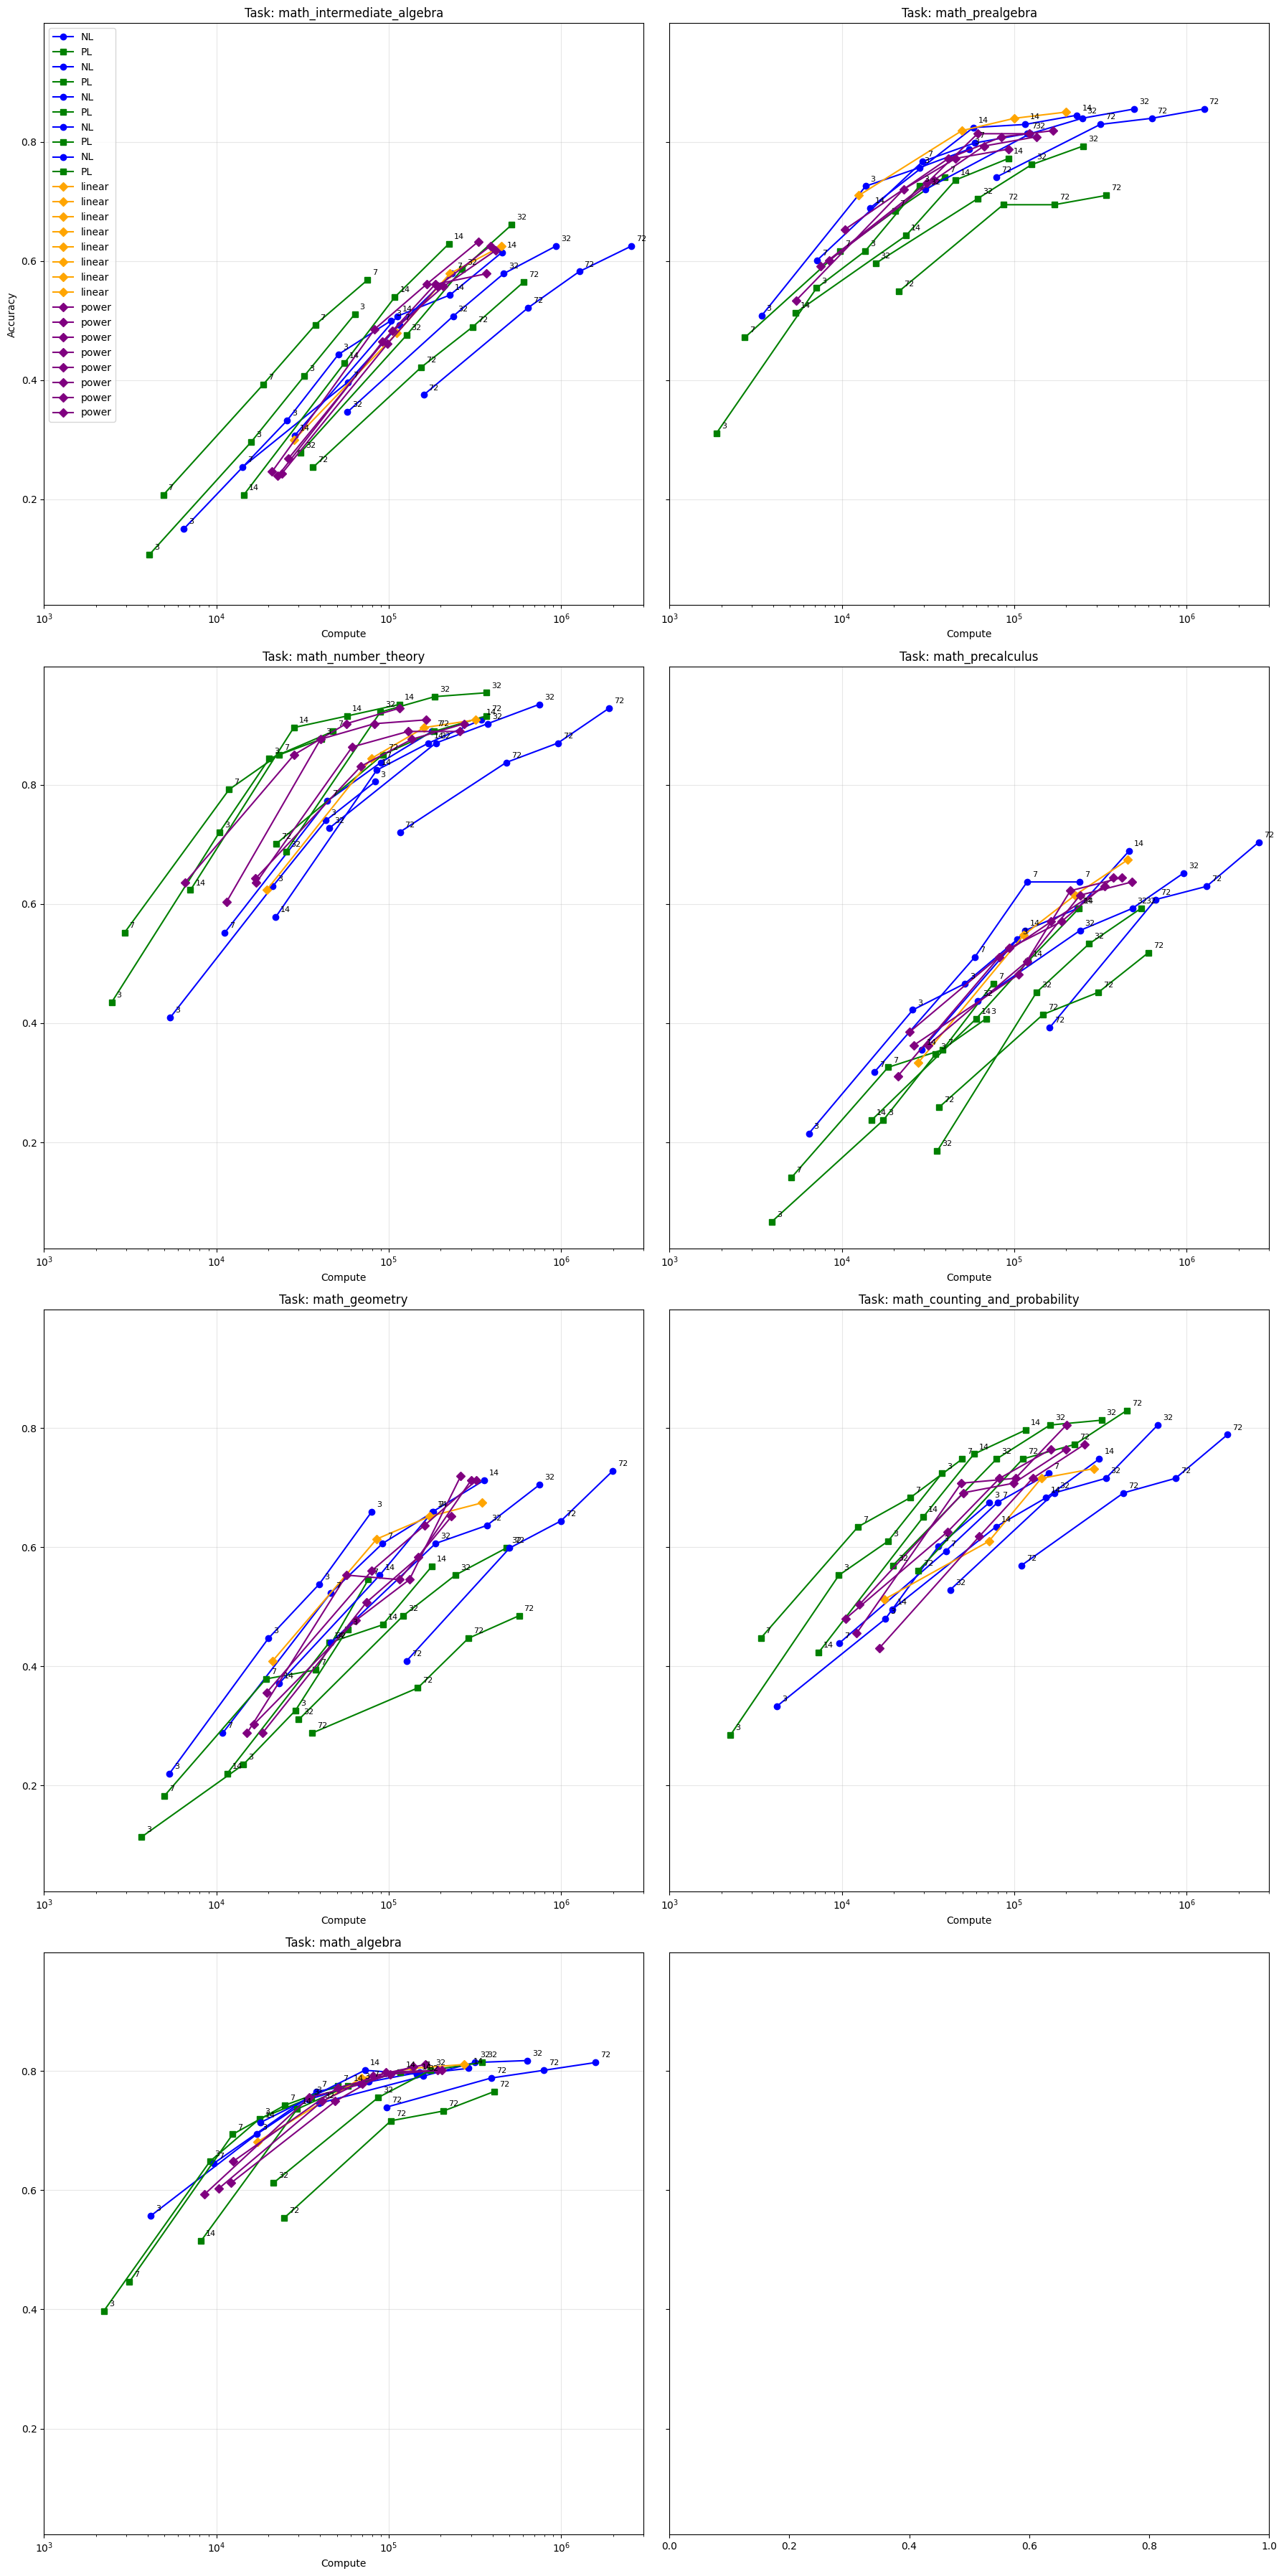

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Create a figure with subplots for each task
tasks = solve_test_df['task'].unique()
fig, axs = plt.subplots(4, len(tasks)//4+1, figsize=(18, 36), sharey=True)

# Color palette for different methods
colors = {
    "NL": "blue", "PL": "green", "routing": "red",
    "linear": "orange", "power": "purple", "linear_softmax": "cyan", "softmax": "magenta", "power_softmax": "brown",
    "0.1": "gray", "1.0": "black"
    }
markers = {"NL": "o", "PL": "s", "routing": "D"}

for i, task in enumerate(tasks):

    # Determine the subplot position
    i_x = i // (len(tasks)//4+1)
    i_y = i % (len(tasks)//4+1)
    ax = axs[i_x][i_y]
    
    # Filter baseline data for this task
    # for N in [1, 4, 8, 16]:
    for size in [3, 7, 14, 32, 72]:
        # Plot baseline models (NL and PL) as lines with points
        for method in ['NL', 'PL']:
            # method_data = task_data[task_data['solve'] == method]
            # method_data = baseline_df.swaplevel(0, 1, axis=1).sort_index(axis=1)[method]
            method_data = baseline_df[method].reset_index()
            method_data = method_data[
                (method_data['task'] == task)
                & (method_data['size'] == size)
                # & (method_data['N'] == N)
                ]
            # Sort by size to connect dots properly
            # method_data = method_data.sort_values('size')
            method_data = method_data.sort_values('N')
            ax.plot(method_data['compute'], method_data['accuracy'], 
                    color=colors[method], marker=markers[method],
                    linestyle='-', label=f"{method}")
            
            # Add model size annotations
            for _, row in method_data.iterrows():
                ax.annotate(f"{row['size']}", 
                        (row['compute'], row['accuracy']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8)
    

    # for model_size in [7, 14, 32]:
    #     method_data = baseline_df["NL"].reset_index()
    #     method_data = method_data[
    #         (method_data['task'] == task)
    #         & (method_data['size'] == model_size)
    #         ]
        
    #     # Sort by size to connect dots properly
    #     # method_data = method_data.sort_values('size')
    #     ax.plot(method_data['compute'], method_data['accuracy'], 
    #             color='red', marker=markers[method],
    #             linestyle='-', label=f"{method}")

    # Plot routing method as a line connecting points for each N
    route_task_data = route_test_df.pivot_table(
        index=["type", "route_size", "lambda", "N", "task"],
        values=["accuracy", "compute"],
    ).reset_index()
    for route_type in route_task_data['type'].unique():
        # if route_type != "softmax":
        # if route_type != "power":
        if route_type not in ["linear", "power"]:
            continue
        for route_size in route_task_data['route_size'].unique():
            for lmbda in route_task_data['lambda'].unique():
                if lmbda not in ["0.1", "1.0"]:
                    continue
                _route_task_data = route_task_data[
                    (route_task_data['task'] == task)
                    & (route_task_data['route_size'] == route_size)
                    & (route_task_data['type'] == route_type)
                    # & (route_task_data['lambda'] == "0.1")
                    & (route_task_data['lambda'] == lmbda)
                    ]
                _route_task_data = _route_task_data.sort_values('N')  # Sort by N to connect dots properly
                ax.plot(
                    _route_task_data['compute'], _route_task_data['accuracy'], 
                    color=colors[route_type],
                    marker=markers['routing'], linestyle='-', label=route_type
                )
    
    # Add annotations for N values
    for _, row in _route_task_data.iterrows():
        ax.annotate(f"N={row['N']}", 
                    (row['compute'], row['accuracy']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8)
    
    # Set titles and labels
    ax.set_title(f'Task: {task}')
    ax.set_xlabel('Compute')
    if i == 0:
        ax.set_ylabel('Accuracy')
    ax.grid(True, alpha=0.3)
    
    # make x-axis logarithmic
    ax.set_xscale('log')
    # x-axis limits
    ax.set_xlim(left=1e3, right=3e6)

    # Only show legend for the first subplot
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

In [88]:
route_test_df.reset_index().pivot_table(
    index=["type", "route_size", "lambda", "N"],
    values=["accuracy", "compute"],
).reset_index()

,type,route_size,lambda,N,accuracy,compute
0,linear,0.5,1.0,1,0.494351,20702.292834
1,linear,0.5,1.0,4,0.651871,83472.023730
2,linear,0.5,1.0,8,0.714894,167011.661265
3,linear,0.5,1.0,16,0.760792,333020.656779
4,linear_softmax,0.5,1.0,1,0.434539,13554.117356
...,...,...,...,...,...,...
75,softmax,3.0,0.8,16,0.748163,214099.774818
76,softmax,3.0,1.0,1,0.360921,9502.706717
77,softmax,3.0,1.0,4,0.583560,37896.815491
78,softmax,3.0,1.0,8,0.660961,76295.889958


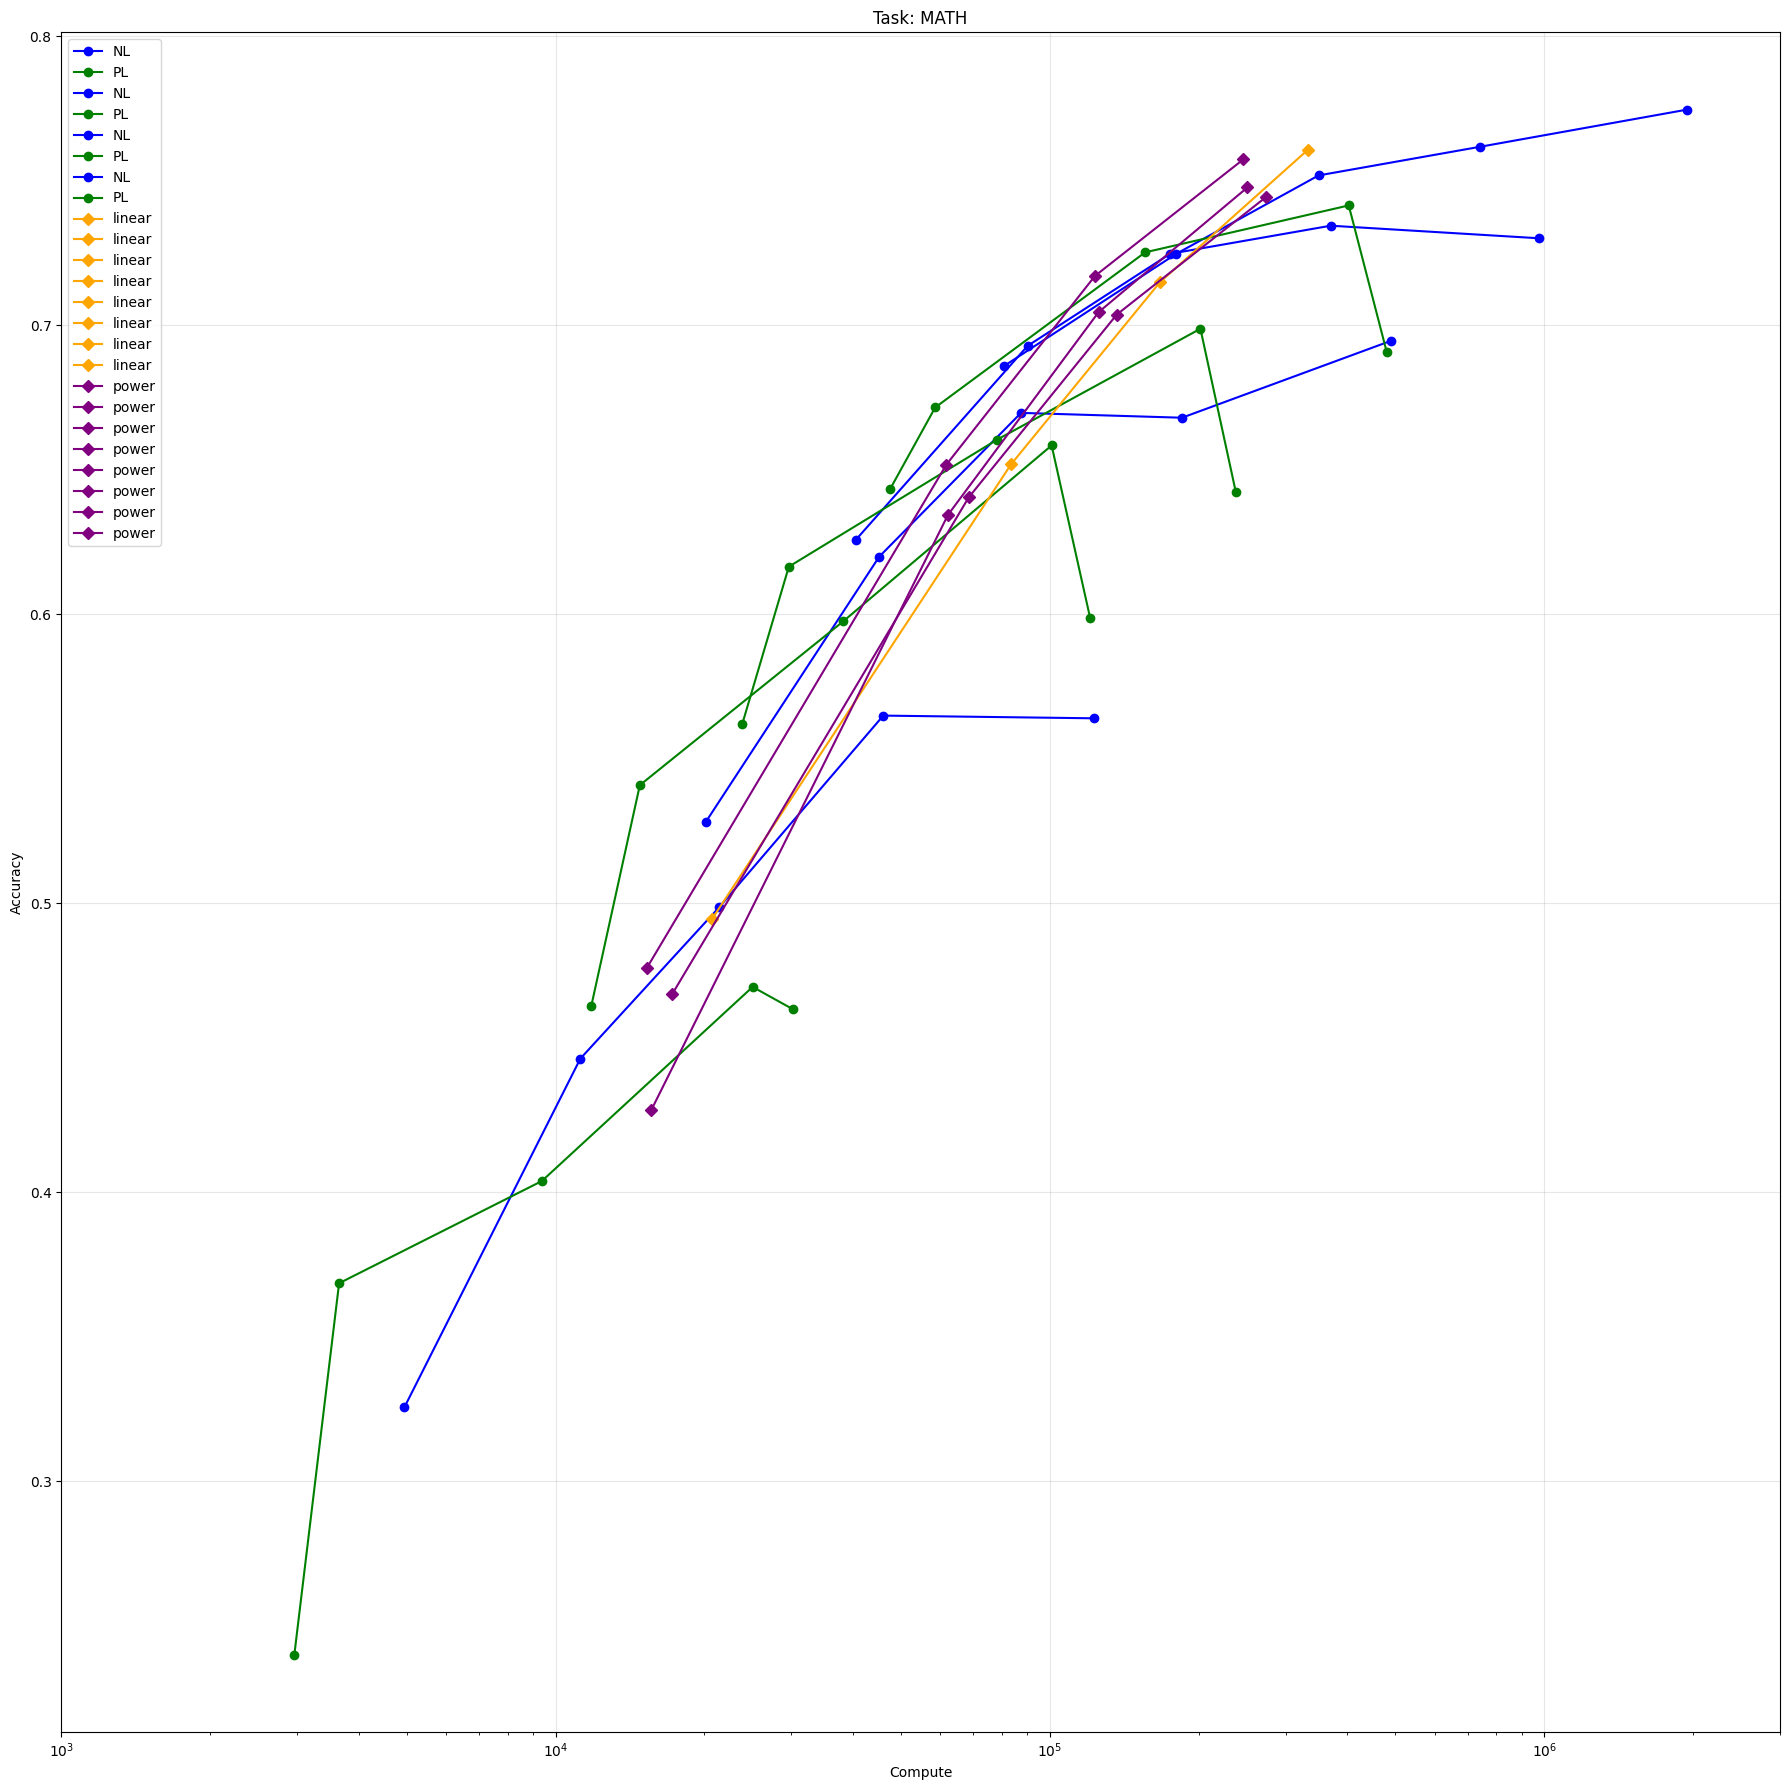

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Create a figure with subplots for each task
tasks = solve_test_df['task'].unique()
fig, ax = plt.subplots(1, 1, figsize=(18, 18), sharey=True)

# Color palette for different methods
colors = {
    "NL": "blue", "PL": "green",
    "linear": "orange", "power": "purple", "linear_softmax": "cyan", "softmax": "magenta", "power_softmax": "brown",
    }
markers = {
    "NL": "o", "PL": "o",
    "routing": "D"
    }

# Filter baseline data for this task
for N in [1, 4, 8, 16]:
    # Plot baseline models (NL and PL) as lines with points
    for method in ['NL', 'PL']:
        # method_data = task_data[task_data['solve'] == method]
        # method_data = baseline_df.swaplevel(0, 1, axis=1).sort_index(axis=1)[method]
        method_data = baseline_df[method].reset_index()
        method_data = method_data[
            # (method_data['task'] == task)
            (method_data['N'] == N)
            ]
        method_data = method_data.pivot_table(
            index="size",
            values=["accuracy", "compute"],
            aggfunc="mean"
        ).reset_index()
        # Sort by size to connect dots properly
        # method_data = method_data.sort_values('size')
        ax.plot(method_data['compute'], method_data['accuracy'], 
                color=colors[method], marker=markers[method],
                linestyle='-', label=f"{method}")

route_task_data = route_test_df.reset_index().pivot_table(
    index=["type", "route_size", "lambda", "N"],
    values=["accuracy", "compute"],
).reset_index()
for route_type in route_task_data['type'].unique():
    if route_type not in ["power", "linear"]:
        continue
    for route_size in route_task_data['route_size'].unique():
        for lmbda in route_task_data['lambda'].unique():
            if lmbda not in ["0.1", "1.0"]:
                continue
            _route_task_data = route_task_data[
                (route_task_data['type'] == route_type)
                & (route_task_data['route_size'] == route_size)
                & (route_task_data['lambda'] == lmbda)
                ]
            # _route_task_data = _route_task_data.sort_values('N')  # Sort by N to connect dots properly
            ax.plot(
                _route_task_data['compute'], _route_task_data['accuracy'], 
                color=colors[route_type],
                marker=markers['routing'], linestyle='-', label=route_type
            )

# Add annotations for N values
for _, row in _route_task_data.iterrows():
    ax.annotate(f"N={row['N']}", 
                (row['compute'], row['accuracy']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8)

# Set titles and labels
ax.set_title(f'Task: MATH')
ax.set_xlabel('Compute')
if i == 0:
    ax.set_ylabel('Accuracy')
ax.grid(True, alpha=0.3)

# make x-axis logarithmic
ax.set_xscale('log')
# x-axis limits
ax.set_xlim(left=1e3, right=3e6)

# Only show legend for the first subplot
if i == 0:
    ax.legend()

plt.tight_layout()
plt.show()